# Attention-based explainability demo

This notebook trains a small GAT on a single preprocessed polymer graph (taken from `data/raw/train.csv`), extracts attention coefficients from the model and from a small HRG variant, and visualizes node-level importances derived from attention.

In [1]:
import os
import sys
from pathlib import Path

# --- FIX for Jupyter Notebooks ---
# Get the current working directory of the notebook kernel
HERE = Path.cwd()

# Ensure repo root is on sys.path when launched from the notebooks/ dir
REPO_ROOT = os.path.abspath(os.path.join(HERE, '..'))
sys.path.insert(0, REPO_ROOT)

print(f"Project root added to path: {REPO_ROOT}")

Project root added to path: c:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction


In [2]:
%matplotlib inline
import torch

# Models / explainers from the repo
from src.models.gat import GATv2
from src.models.explainability.attention_based import attention_node_importance
from src.preprocessing.oligomer import OligomerPreprocessor
from src.loss.masked_loss import WeightedMAELoss
from src.models.gat import GATv2
from src.models.explainability.GNNExplainer import visualize_node_importance

# Train a GAT on the full dataset for a single epoch (follows the approach in `gcn_explainability.ipynb`)
import os
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Lightning and callbacks
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Small helper dataset wrapper (compatible with main.py contract)
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

# Lightning wrapper (same contract as main.py LightningModel)
class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer, scheduler, loss_fn, batch_size, hparams=None):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.batch_size = batch_size
        if hparams:
            self.save_hyperparameters(hparams)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def configure_optimizers(self):
        if self.scheduler is not None:
            return [self.optimizer], [self.scheduler]
        else:
            return [self.optimizer]

# Determine repo root and data path
repo_root = REPO_ROOT if 'REPO_ROOT' in globals() else os.path.abspath('..')
data_csv = os.path.join(repo_root, 'data', 'raw', 'train.csv')
print('Reading data file:', data_csv)

df = pd.read_csv(data_csv)
X = df['SMILES'].values
# labels in this repo are (Tg, FFV, Tc, Density, Rg)
Y = df[['Tg','FFV','Tc','Density','Rg']].values

# Train/Val/Test split (use same ratios as main.py)
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.17, random_state=42)

print('Preprocessing (may take a moment)…')
prep = OligomerPreprocessor(oligomer_len=1)
X_train_graphs = prep.fit_transform(X_train)
X_val_graphs = prep.transform(X_val)
X_test_graphs = prep.transform(X_test)

# compute loss stats robustly (handle NaNs)
import numpy as np
property_ranges = torch.tensor([ np.nanmax(Y[:,i]) - np.nanmin(Y[:,i]) for i in range(Y.shape[1]) ], dtype=torch.float32)
num_samples_per_property = torch.tensor([ np.sum(~np.isnan(Y[:,i])) for i in range(Y.shape[1]) ], dtype=torch.float32)
loss_fn = WeightedMAELoss(property_ranges, num_samples_per_property)

# dataloaders
batch_size = 32
train_dl = DataLoader(GraphDataset(X_train_graphs, Y_train), batch_size=batch_size, shuffle=True)
val_dl = DataLoader(GraphDataset(X_val_graphs, Y_val), batch_size=batch_size)
test_dl = DataLoader(GraphDataset(X_test_graphs, Y_test), batch_size=batch_size)

# instantiate model using detected in_channels from graphs
in_ch = X_train_graphs[0].x.size(1) if len(X_train_graphs)>0 else 9
model = GATv2(in_channel=in_ch, hidden_channels=[64], hidden_layers=[32], heads=4).to('cpu')

# optimizer/scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = None

# Lightning wrapper and callbacks
lightning_model = LightningModel(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, batch_size=batch_size, hparams={})
ckpt_dir = os.path.join(repo_root, 'checkpoints')
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_cb = ModelCheckpoint(dirpath=ckpt_dir, filename='gat_explain_best', monitor='val_loss', save_top_k=1, mode='min')

# offline wandb logger to avoid cloud
logger_dir = os.path.join(repo_root, 'lightning_logs')
logger = WandbLogger(project='polymer-prediction', offline=True, save_dir=logger_dir)

# Train for 3 epoch (use CPU to be robust across environments)
trainer = pl.Trainer(max_epochs=3, accelerator='cpu', logger=logger, callbacks=[ckpt_cb])
print('Starting training (3 epoch) on full dataset...')
trainer.fit(lightning_model, train_dl, val_dl)
print('Training finished.')
trainer.test(lightning_model, test_dl)

# Use trained model in memory for explainers
trained_model = lightning_model.model
trained_model.eval()



Reading data file: c:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction\data\raw\train.csv
Preprocessing (may take a moment)…


Processing SMILES string to oligomer of length 1: 100%|██████████| 5624/5624 [00:07<00:00, 796.76it/s]
Processing SMILES string to oligomer of length 1:   0%|          | 0/1153 [00:00<?, ?it/s]
Processing SMILES string to oligomer of length 1: 100%|██████████| 1196/1196 [00:01<00:00, 836.46it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training (3 epoch) on full dataset...


C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was 

C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\20210926\Desktop\Personal\university\TU Deflt\Sem 1\Data science GML\Project\dsait-4305-polymer-prediction\checkpoints exists and is not empty.

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | model   | GATv2           | 31.1 K | train
1 | loss_fn | WeightedMAELoss | 0      | train
----------------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\utils\sparse.py:276: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(
C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12

Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.89it/s, v_num=a2e1, train_loss_step=0.117, val_loss=0.135, train_loss_epoch=0.138] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 176/176 [00:08<00:00, 21.85it/s, v_num=a2e1, train_loss_step=0.117, val_loss=0.135, train_loss_epoch=0.138]

C:\Users\20210926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Training finished.
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 53.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.11690574139356613
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 53.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.11690574139356613
───────────────────────────────────────────────────

GATv2(
  (attention_layers): ModuleList(
    (0): GATv2Conv(9, 64, heads=4)
    (1): Linear(in_features=256, out_features=64, bias=True)
  )
  (pooling1): ASAPooling(64, ratio=0.5)
  (fcs): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
  (act): ELU(alpha=1.0)
)

Visualise:

Selected SMILES for explanation: *CC(*)c1ccccc1C(=O)OCCCCCC


Processing SMILES string to oligomer of length 1: 100%|██████████| 1/1 [00:00<00:00, 663.45it/s]

forward_attn_extracted: found
forward_attn_layer_0 0.0 1.0


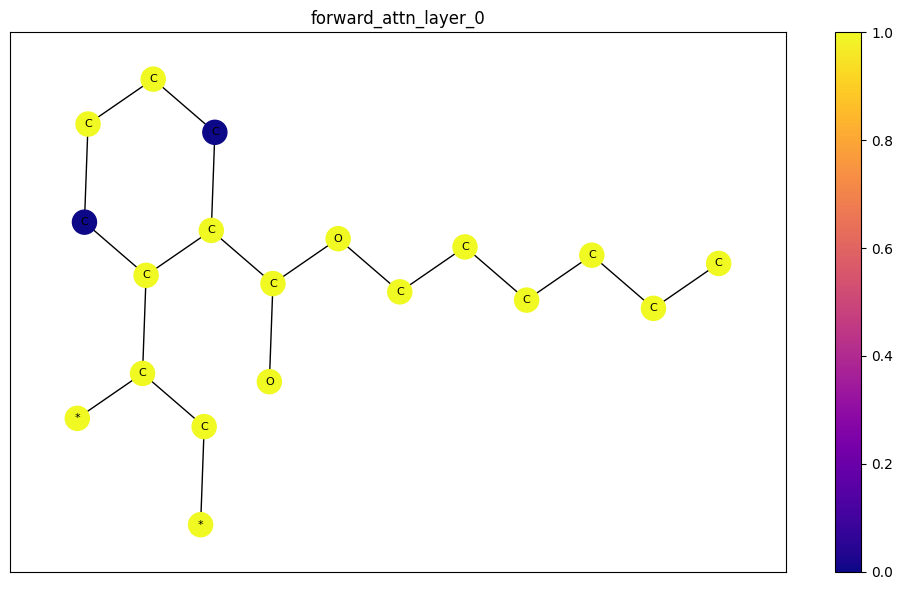

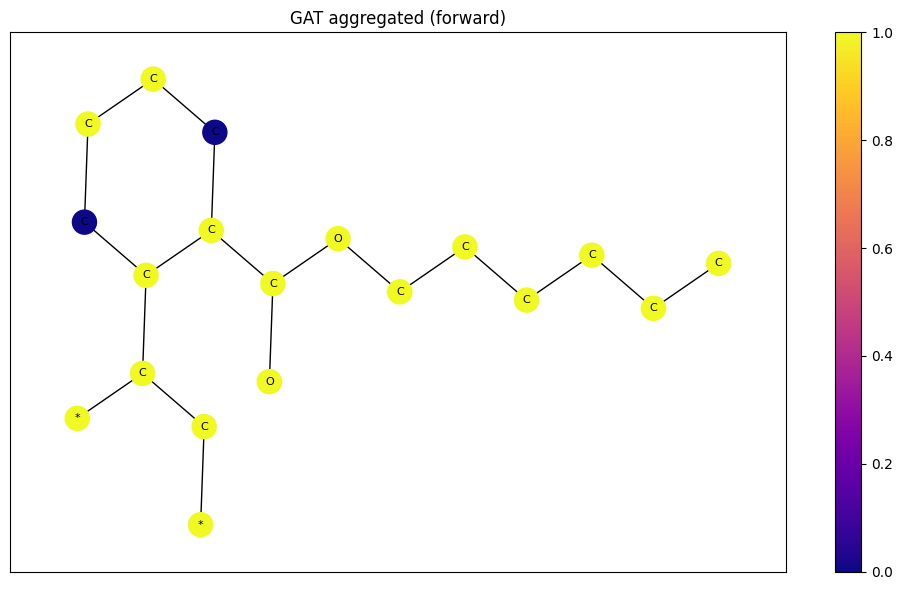

In [8]:
# Select a SMILES to explain (choose a deterministic one for reproducibility)
selected_smiles = df['SMILES'].dropna().iloc[0]
print('Selected SMILES for explanation:', selected_smiles)

# Preprocess the chosen SMILES into a graph using the same preprocessor
graphs_for_explain = prep.transform([selected_smiles])
if len(graphs_for_explain) == 0:
    raise RuntimeError('Preprocessing returned no graph for chosen SMILES')
data = graphs_for_explain[0]
# ensure batch index exists for PyG
n_nodes = int(data.x.size(0))
data.batch = torch.zeros(n_nodes, dtype=torch.long)

# Try to extract attention returned by the model forward; fall back to module probing
from src.models.explainability.attention_based import extract_node_importance_from_forward, attention_node_importance as probe_attention_node_importance
res = extract_node_importance_from_forward(trained_model, data)
print('forward_attn_extracted:', 'found' if res else 'none')
if res:
    for name, scores in res['per_layer']:
        print(name, float(scores.min()), float(scores.max()))
        visualize_node_importance(data, scores, title=name)
    visualize_node_importance(data, res['aggregated'], title='GAT aggregated (forward)')
else:
    print('No forward attentions; falling back to module probing')
    expl = probe_attention_node_importance(trained_model, data)
    for name, scores in expl['per_module']:
        print(name, float(scores.min()), float(scores.max()))
        visualize_node_importance(data, scores, title=name)
    visualize_node_importance(data, expl['aggregated'], title='GAT aggregated (probe)')

## Notes
- If attention arrays look degenerate (all zeros), try training longer, change the task/target, or inspect the created attention modules for compatibility with `return_attention_weights=True`.
- If you want to save these visualizations as files instead of displaying inline, add `plt.savefig(...)` calls.
- I can add a unit test to assert that `model(data, return_attn=True)` returns a non-empty attention list for a minimal configuration.